# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### А ещё есть консультация 2023 года :)

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

Отдельная благодарность А. Абрамову за написание assert для проверки функций и В. Гилязову за поясняющую картинку.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

#Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2024-11-23 06:12:41--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2024-11-23 06:12:41--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   132MB/s    in 0.3s    

2024-11-23 06:12:43 (132 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.

        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        class_id = class_dict[member.find("name").text]

        res =  [xmin, ymin, xmax, ymax, class_id]

        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = Image.open(fname).convert("RGB")
        image = np.array(image)
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        img = images[i].permute(1, 2, 0).numpy()
        img = img * std + mean
        img = (img * 255).astype("uint8")


        # Вот тут покажите картинку после отката нормализации
        ax.imshow(img)

        for bbox in bboxes[i]:

          # Вот тут нарисуйте бибоксы
          xmin, ymin, xmax, ymax, class_id = bbox

          rect = Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor="red", facecolor="none"
            )
          ax.add_patch(rect)

          class_name = train_ds.class_dict_inv[class_id]
          ax.text(
                xmin, ymin - 5, class_name,
                color="red", fontsize=8, bbox=dict(facecolor="white", alpha=0.5)
            )



    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

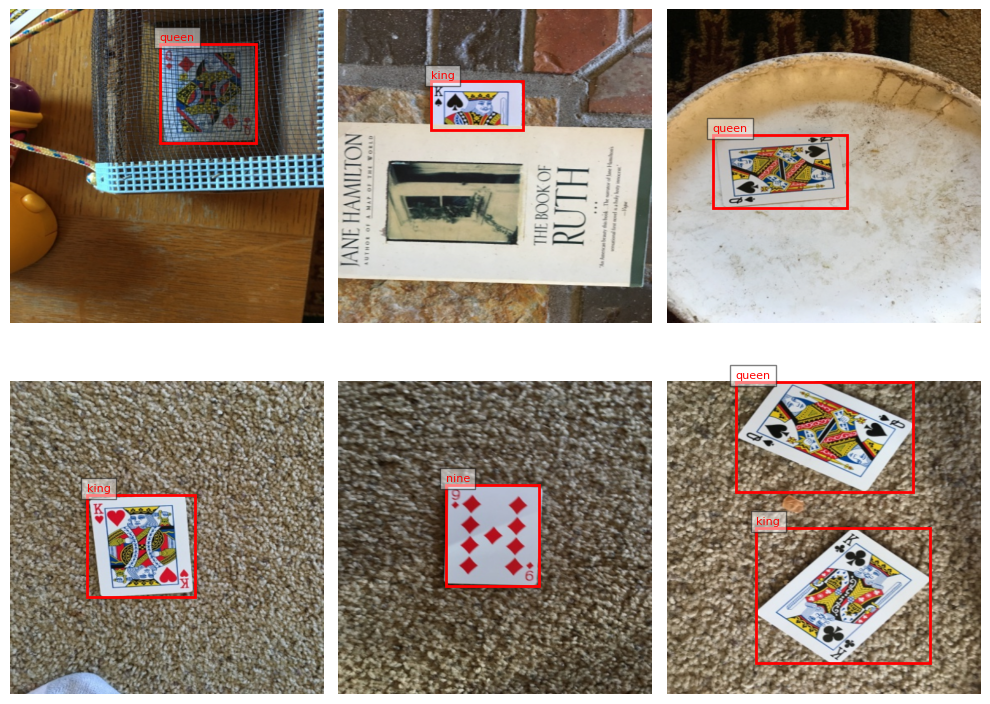

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код.

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  w / (w // downsample)
        y_cell =  h / (h // downsample)

        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box =  (xmax - xmin) / w
        h_box =  (ymax - ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx =  (xmin + xmax) / 2
        cy =  (ymin + ymax) / 2
        cx_idx =  (cx / x_cell).long()
        cy_idx =  (cy / y_cell).long()

        cx_box =  (cx / x_cell) - cx_idx.float()
        cy_box = (cy / y_cell) - cy_idx.float()

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [10]:
def test_collate_fn() -> None:
    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class
    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class
    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }
    ])

    # Проверяем размерности
    assert result['image'].shape == (2, 3, 512, 512)
    assert result['target'].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))
    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))
    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

    # Проверяем, что все остальные клеточки содержат нули
    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)
    assert np.allclose(result['target'], 0)

test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

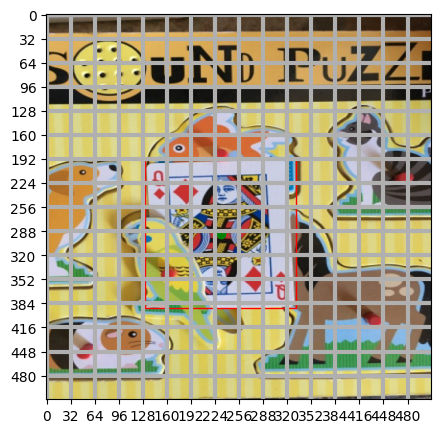

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [12]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample


    if c == 6:

        cx_box, cy_box, w_box, h_box, confidence, classes = pred[:, 0, :, :], pred[:, 1, :, :], \
                                                            pred[:, 2, :, :], pred[:, 3, :, :], \
                                                            pred[:, 4, :, :], pred[:, 5, :, :]
    else:

        cx_box, cy_box, w_box, h_box, confidence = pred[:, 0, :, :], pred[:, 1, :, :], \
                                                   pred[:, 2, :, :], pred[:, 3, :, :], pred[:, 4, :, :]

        class_logits = pred[:, 5:, :, :]
        classes = torch.argmax(class_logits, dim=1)

    bboxes_batch = []

    for batch_idx in range(b):
        bboxes = []
        for y_idx in range(h):
            for x_idx in range(w):
                if confidence[batch_idx, y_idx, x_idx] >= threshold:

                    cx = (x_idx + cx_box[batch_idx, y_idx, x_idx].item()) * (img_w / w)
                    cy = (y_idx + cy_box[batch_idx, y_idx, x_idx].item()) * (img_h / h)


                    bw = w_box[batch_idx, y_idx, x_idx].item() * img_w
                    bh = h_box[batch_idx, y_idx, x_idx].item() * img_h


                    xmin = int(cx - bw / 2)
                    ymin = int(cy - bh / 2)
                    xmax = int(cx + bw / 2)
                    ymax = int(cy + bh / 2)


                    class_id = int(classes[batch_idx, y_idx, x_idx].item())


                    bboxes.append([xmin, ymin, xmax, ymax, class_id])
        bboxes_batch.append(bboxes)

    return bboxes_batch


Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [13]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [ [ 100, 200, 200, 300, 2 ] ]
    target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]
    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }
    ])

    target = result['target']
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Добавляем два канала
    assert target.shape == (2, 8, 16, 16) # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print('Actual:  ', actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [ target1, [ target2[1], target2[0] ] ]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print('Expected:', expected)

    # Сравниваем
    assert actual == expected

test_decode_predictions()

Actual:   [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [14]:
C =  len(train_ds.class_dict)


class Detector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

        self.backbone = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )

        self.conv_layers = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + self.num_classes, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.backbone(img)
        x = self.conv_layers(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [15]:
def special_loss(pred, target, C=C):

    mse_loss = nn.MSELoss(reduction='sum')
    bce_loss = nn.BCELoss(reduction='sum')
    cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')

    obj_mask = target[:, 4, :, :] > 0
    noobj_mask = ~obj_mask

    obj_mask = obj_mask.unsqueeze(1)

    pred_coords = pred[:, :2, :, :]
    target_coords = target[:, :2, :, :]

    pred_coords_masked = pred_coords[obj_mask.expand_as(pred_coords)]
    target_coords_masked = target_coords[obj_mask.expand_as(target_coords)]
    localization_loss = mse_loss(pred_coords_masked, target_coords_masked)


    pred_wh = torch.sqrt(pred[:, 2:4, :, :].clamp(min=1e-6))
    target_wh = torch.sqrt(target[:, 2:4, :, :].clamp(min=1e-6))

    pred_wh_masked = pred_wh[obj_mask.expand_as(pred_wh)]
    target_wh_masked = target_wh[obj_mask.expand_as(target_wh)]
    box_loss = mse_loss(pred_wh_masked, target_wh_masked)

    pred_classes = pred[:, 5:, :, :]
    target_classes = target[:, 5:, :, :]

    pred_classes_masked = pred_classes[obj_mask.squeeze(1).unsqueeze(2).expand_as(pred_classes)]
    target_classes_masked = target_classes[obj_mask.squeeze(1).unsqueeze(2).expand_as(target_classes)]
    classification_loss = cross_entropy_loss(
        pred_classes_masked.view(-1, C), target_classes_masked.argmax(dim=1)
    )

    pred_conf = pred[:, 4, :, :]
    target_conf = target[:, 4, :, :]
    obj_conf_loss = bce_loss(
        pred_conf[obj_mask.squeeze(1)], target_conf[obj_mask.squeeze(1)]
    )
    noobj_conf_loss = 0.1 * bce_loss(
        pred_conf[noobj_mask], target_conf[noobj_mask]
    )
    confidence_loss = obj_conf_loss + noobj_conf_loss

    return localization_loss + box_loss + classification_loss + confidence_loss

In [24]:
def special_loss(pred, target, C=C):

    mse_loss = nn.MSELoss(reduction='sum')
    bce_loss = nn.BCELoss(reduction='sum')
    cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')


    obj_mask = target[:, 4, :, :] > 0
    noobj_mask = ~obj_mask


    obj_mask = obj_mask.unsqueeze(1)


    pred_coords = pred[:, :2, :, :]
    target_coords = target[:, :2, :, :]

    pred_coords_masked = pred_coords[obj_mask.expand_as(pred_coords)]
    target_coords_masked = target_coords[obj_mask.expand_as(target_coords)]
    localization_loss = mse_loss(pred_coords_masked, target_coords_masked)

    pred_wh = torch.sqrt(pred[:, 2:4, :, :].clamp(min=1e-6))
    target_wh = torch.sqrt(target[:, 2:4, :, :].clamp(min=1e-6))

    pred_wh_masked = pred_wh[obj_mask.expand_as(pred_wh)]
    target_wh_masked = target_wh[obj_mask.expand_as(target_wh)]
    box_loss = mse_loss(pred_wh_masked, target_wh_masked)

    target_classes = target[:, 5:, :, :]
    target_classes = target_classes.argmax(dim=1)

    obj_mask_squeezed = obj_mask.squeeze(1)

    positive_indices = obj_mask_squeezed.nonzero(as_tuple=True)

    pred_classes = pred[:, 5:, :, :]
    pred_classes = pred_classes.permute(0, 2, 3, 1)
    pred_classes_masked = pred_classes[positive_indices]

    target_classes_masked = target_classes[positive_indices].long()

    classification_loss = cross_entropy_loss(pred_classes_masked, target_classes_masked)

    pred_conf = pred[:, 4, :, :]
    target_conf = target[:, 4, :, :]

    obj_conf_loss = bce_loss(
        pred_conf[obj_mask.squeeze(1)], target_conf[obj_mask.squeeze(1)]
    )
    noobj_conf_loss = 0.1 * bce_loss(
        pred_conf[noobj_mask], target_conf[noobj_mask]
    )
    confidence_loss = obj_conf_loss + noobj_conf_loss

    return localization_loss + box_loss + classification_loss + confidence_loss

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [17]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15
model = Detector(num_classes=C).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:

        images = batch["image"].to(device)
        targets = batch["target"].to(device)


        opt.zero_grad()
        predictions = model(images)

        loss = special_loss(predictions, targets, C)
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_description(f"Train Loss: {loss.item():.4f}")


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 92.775;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 37.718;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 31.152;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 29.397;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 25.653;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 24.683;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 23.957;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 22.580;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 22.095;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 22.499;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 23.749;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 24.378;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 23.798;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 21.952;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 22.458;


Запустим обученный детектор на тестовых изображениях:

In [27]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [28]:
# Нужно сделать предсказание и переложить результат на cpu

images = batch["image"].to(device)

with torch.no_grad():
    predictions = model(images)
    predictions = predictions.cpu()

print("Predictions shape:", predictions.shape)

Predictions shape: torch.Size([6, 11, 16, 16])


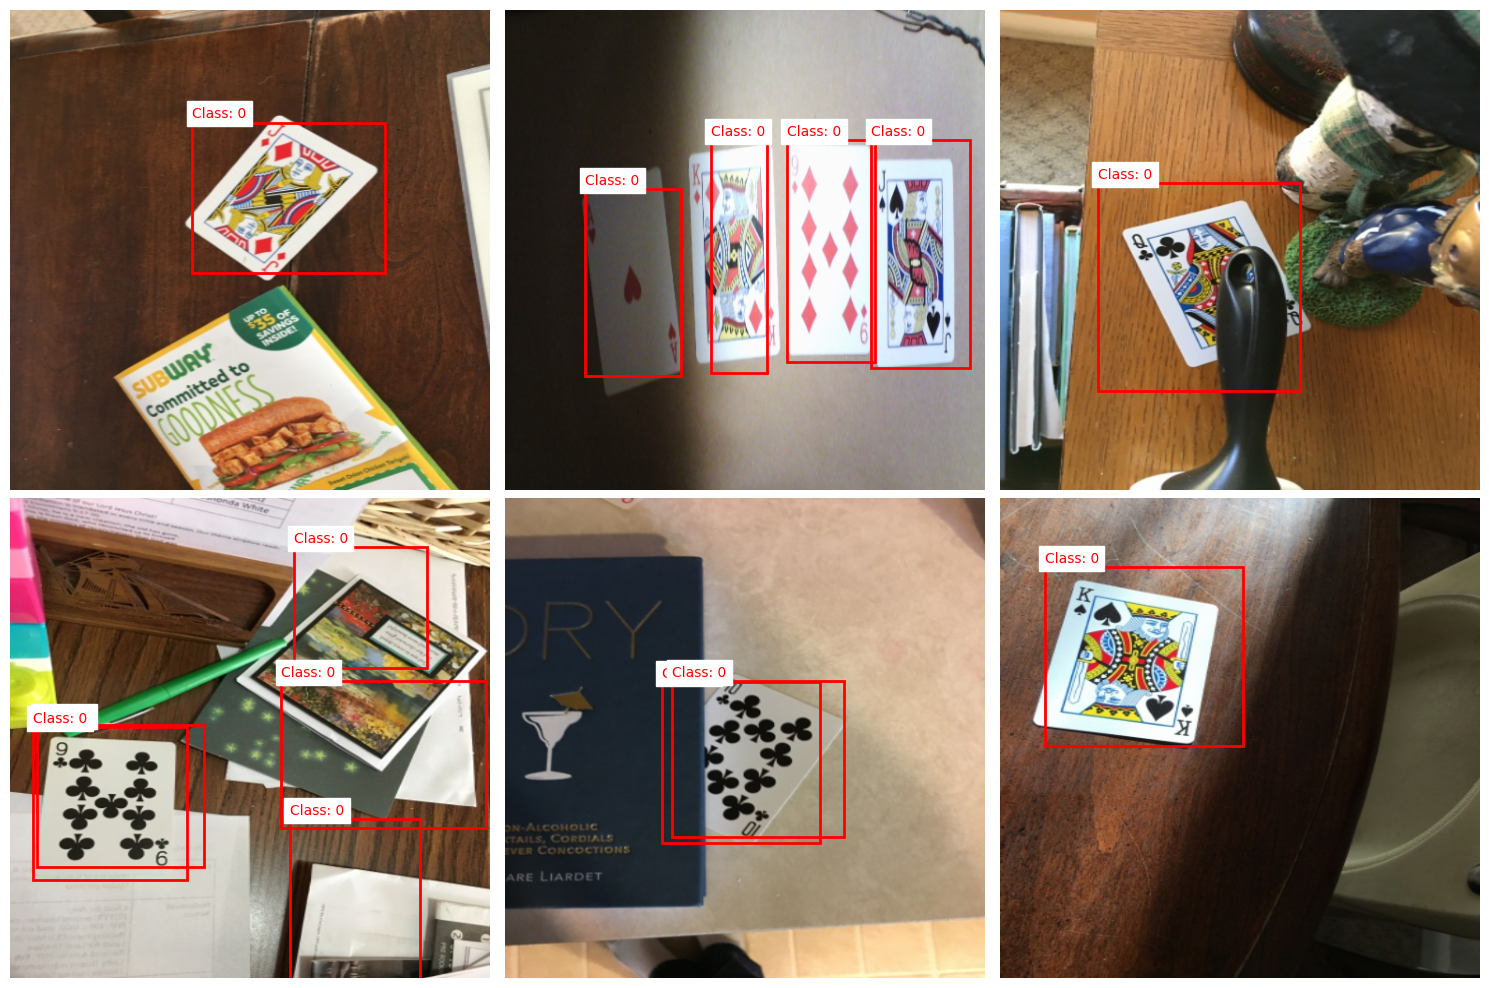

In [31]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
threshold = 0.1  # Установим порог
decoded_predictions = [decode_prediction(pred.unsqueeze(0), upsample=32, threshold=threshold) for pred in predictions]

# Визуализация предсказаний
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(images):
        break

    img = images[i].permute(1, 2, 0).cpu().numpy() * std + mean
    img = img.clip(0, 1)
    bboxes = decoded_predictions[i]


    ax.imshow(img)
    ax.axis("off")


    for bbox_list in bboxes:
        if isinstance(bbox_list[0], (list, tuple)):
            for bbox in bbox_list:
                xmin, ymin, xmax, ymax, class_id = bbox
                w = xmax - xmin
                h = ymax - ymin
                ax.add_patch(
                    Rectangle(
                        (xmin, ymin), w, h,
                        edgecolor="red", facecolor="none", linewidth=2
                    )
                )
                ax.text(
                    xmin, ymin - 5, f"Class: {class_id}",
                    color="red", fontsize=10, backgroundcolor="white"
                )
        else:
            xmin, ymin, xmax, ymax, class_id = bbox_list
            w = xmax - xmin
            h = ymax - ymin
            ax.add_patch(
                Rectangle(
                    (xmin, ymin), w, h,
                    edgecolor="red", facecolor="none", linewidth=2
                )
            )
            ax.text(
                xmin, ymin - 5, f"Class: {class_id}",
                color="red", fontsize=10, backgroundcolor="white"
            )

fig.tight_layout()
plt.show()

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [39]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 39.2 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [40]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [41]:
def annotation2txt(bboxes, w_im, h_im):
    lines = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_id = bbox

        x_center = (xmin + xmax) / 2.0
        y_center = (ymin + ymax) / 2.0

        width = xmax - xmin
        height = ymax - ymin

        x_center_norm = min(max(x_center / w_im, 0), 1)
        y_center_norm = min(max(y_center / h_im, 0), 1)
        width_norm = min(max(width / w_im, 0), 1)
        height_norm = min(max(height / h_im, 0), 1)

        line = f"{int(class_id)} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
        lines.append(line)

    return lines

In [42]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [45]:
# Собираем YAML

nc =   len(train_ds.class_dict)
id_to_class = {v: k for k, v in train_ds.class_dict.items()}
names = [id_to_class[i] for i in range(nc)]
names= '[' + ', '.join(f"'{name}'" for name in names) + ']'

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [46]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')
model.train(data='data.yaml', epochs=15)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 182MB/s]

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 44.6MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 1766.00it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1327.63it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      14.4G     0.6313      3.363       1.04         27        640: 100%|██████████| 21/21 [00:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all         37         65    0.00419      0.193     0.0266     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.89G     0.6315      2.824      1.024         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         37         65    0.00228       0.14     0.0156     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15       2.9G     0.6246      2.275      1.005         19        640: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         37         65     0.0592     0.0573      0.031     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.93G     0.6445      1.939      1.008         22        640: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         37         65     0.0517      0.098     0.0353     0.0339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.89G     0.6343      1.832       1.02         14        640: 100%|██████████| 21/21 [00:06<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         37         65     0.0713     0.0684     0.0508     0.0461


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.99G     0.5098       1.92     0.9071         13        640: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         37         65        0.1     0.0911     0.0578     0.0539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.89G     0.4825      1.774     0.8968         11        640: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         37         65     0.0798      0.106     0.0361     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.89G     0.4799      1.686     0.8931         11        640: 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         65     0.0945      0.111     0.0363     0.0334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.91G     0.4512      1.573     0.8635         16        640: 100%|██████████| 21/21 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         37         65      0.108      0.111     0.0337     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.92G     0.4317      1.406     0.8619         10        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


                   all         37         65      0.118      0.111     0.0482     0.0476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.89G     0.4045      1.335     0.8484          9        640: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         37         65      0.109      0.111     0.0351     0.0348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.89G     0.4072      1.296     0.8454          8        640: 100%|██████████| 21/21 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         37         65      0.146      0.111     0.0315     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.91G      0.377      1.203     0.8463          9        640: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         37         65      0.084      0.111     0.0334     0.0316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.92G     0.3656      1.165     0.8576         17        640: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         37         65       0.12      0.111     0.0365     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.89G     0.3538      1.086     0.8299         13        640: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         37         65      0.133      0.111     0.0316     0.0298



15 epochs completed in 0.041 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


                   all         37         65     0.0996     0.0909     0.0578     0.0539
                  king         13         13      0.111     0.0341     0.0312     0.0279
                  jack          9          9      0.125      0.111     0.0388     0.0386
                   ace         14         15      0.258      0.267      0.232      0.212
                   ten          7          8          0          0          0          0
                  nine         13         15      0.104      0.133     0.0451     0.0451
                 queen          5          5          0          0   0.000417   4.17e-05
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b0c8ef1fc40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.


image 1/37 /content/valid/images/IMG_2383.JPG: 640x480 1 ace, 47.3ms
image 2/37 /content/valid/images/IMG_2384.JPG: 640x480 (no detections), 8.5ms
image 3/37 /content/valid/images/IMG_2389.JPG: 640x480 1 ace, 8.5ms
image 4/37 /content/valid/images/IMG_2391.JPG: 640x480 (no detections), 8.7ms
image 5/37 /content/valid/images/IMG_2409.JPG: 640x480 1 ten, 15.4ms
image 6/37 /content/valid/images/IMG_2419.JPG: 640x480 2 queens, 13.9ms
image 7/37 /content/valid/images/IMG_2437.JPG: 640x480 1 ten, 14.6ms
image 8/37 /content/valid/images/IMG_2442.JPG: 640x480 (no detections), 19.4ms
image 9/37 /content/valid/images/IMG_2455.JPG: 640x480 (no detections), 27.2ms
image 10/37 /content/valid/images/IMG_2461.JPG: 640x480 (no detections), 19.9ms
image 11/37 /content/valid/images/IMG_2464.JPG: 640x480 (no detections), 28.9ms
image 12/37 /content/valid/images/IMG_2479.JPG: 640x480 (no detections), 15.2ms
image 13/37 /content/valid/images/IMG_2491.JPG: 640x480 1 ten, 17.0ms
image 14/37 /content/valid/i

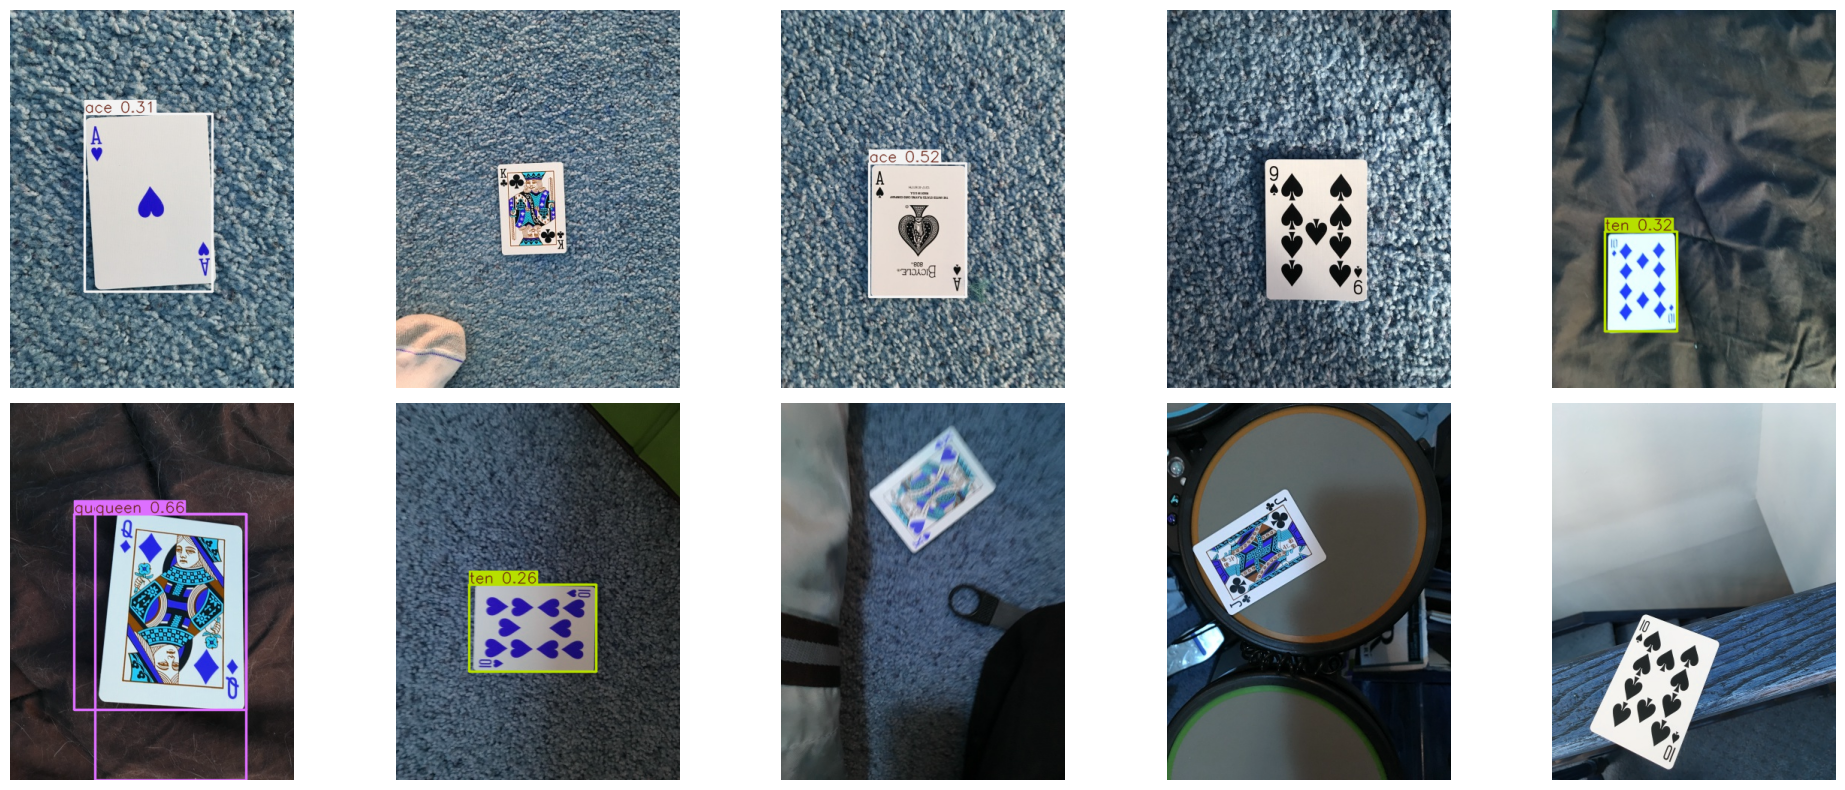

In [47]:
results = model.predict(source='valid/images', save=False)

num_images_to_display = min(10, len(results))
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for idx, result in enumerate(results[:num_images_to_display]):

    img = result.plot()
    ax = axs[idx // 5, idx % 5]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()